In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import time
import math

from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Models

* FM

In [2]:
class FM(nn.Module):
    def __init__(self, n, k):
        super(FM, self).__init__()
        self.n = n
        self.k = k
        self.Feature_Matrix = nn.Parameter(torch.randn(n, k), requires_grad=True)
        self.linear = nn.Linear(n, 1)

    def forward(self, x):
        linear_Layer = self.linear(x)

        p1 = torch.matmul(x, self.Feature_Matrix).pow(2)
        p2 = torch.matmul(x.pow(2), self.Feature_Matrix.pow(2))

        interaction_layer = 0.5 * (p1 - p2).sum(dim=1, keepdim=True)

        return linear_Layer + interaction_layer
        

* BPR Loss

In [18]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class BPRLoss():
    def __init__(self):
        super(BPRLoss, self).__init__()
        self.item1 = item1
        self.item2 = item2

    def forward(self, item1, item2):
        dist = item1 - item2
        # Wait for the summation
        return -np.log(sigmoid(dist))


# Train

In [3]:
# Data Preparation


class MovieLens(Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        x = self.feature[idx]
        y = self.label[idx]
        return x, y
    
def data_tensor(dataset):

    scaler = MinMaxScaler()

    # label = torch.tensor(dataset['rating'].values, dtype=torch.float32)
    # dataset.drop(columns=['timestamps','rating'], inplace=True)
    # features = torch.tensor(dataset.values, dtype=torch.float32)
    
    label = torch.tensor(dataset['rating'].values).float()
    dataset.drop(columns=['timestamps','rating'], inplace=True)
    features = scaler.fit_transform(dataset.values)
    features = torch.tensor(features).float()


    return MovieLens(features, label)

In [10]:
batch_size = 1024

train_set = pd.read_csv("./data/train_set.csv", header=0)
val_set = pd.read_csv("./data/val_set.csv", header=0)
test_set = pd.read_csv("./data/test_set.csv", header=0)

train_set = data_tensor(train_set)
val_set = data_tensor(val_set)
test_set = data_tensor(test_set)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True) 

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, dataloader, optimizer, criterion):
    train_loss = 0
    model.train()
    for feature, label in dataloader:
        feature, label = feature.to(device), label.to(device).unsqueeze(1)
        # print("=======")
        # print("feature = ", feature)
        optimizer.zero_grad()
        y_hat = model(feature)
        loss = criterion(y_hat, label)
        train_loss += loss.item() * feature.shape[0]
        # print("loss = ", loss)

        loss.backward()
        optimizer.step()

    # print("LOSS = ", train_loss)

    return train_loss / len(dataloader.dataset)


In [12]:
def validation(model, dataloader, criterion):
    val_loss = 0
    model.eval()
    for feature, label in dataloader:
        feature, label = feature.to(device), label.to(device).unsqueeze(1)
        with torch.no_grad():
            y_hat = model(feature.to(device))
        loss = criterion(y_hat, label)
        val_loss += loss.item() * feature.shape[0]

    return val_loss / len(dataloader.dataset)

In [13]:
model = FM(5,5)
wd=1e-5
lr=1e-3
epochs=10

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8], gamma=0.1)
criterion = nn.MSELoss().to(device)

train_loss_list = []
val_loss_list = []

for epoch in range(epochs):

    train_loss = train(model, train_dataloader, optimizer, criterion)
    val_loss = validation(model, val_dataloader, criterion)
    scheduler.step()

    sqrt_train_loss = (math.sqrt(train_loss))
    sqrt_val_loss = (math.sqrt(val_loss))
    
    print(f'epoch {epoch}')
    print(f'\ttrain loss: {sqrt_train_loss:.4f}')
    print(f'\tvalidation loss: {sqrt_val_loss:.4f}')
    
    train_loss_list.append(sqrt_train_loss)
    val_loss_list.append(sqrt_val_loss)


epoch 0
	train loss: 1.5939
	validation loss: 0.7352
epoch 1
	train loss: 0.6125
	validation loss: 0.5467
epoch 2
	train loss: 0.5175
	validation loss: 0.5170
epoch 3
	train loss: 0.5047
	validation loss: 0.5105
epoch 4
	train loss: 0.4992
	validation loss: 0.5064
epoch 5
	train loss: 0.4957
	validation loss: 0.5054
epoch 6
	train loss: 0.4938
	validation loss: 0.5038
epoch 7
	train loss: 0.4928
	validation loss: 0.5024
epoch 8
	train loss: 0.4924
	validation loss: 0.5028
epoch 9
	train loss: 0.4923
	validation loss: 0.5031


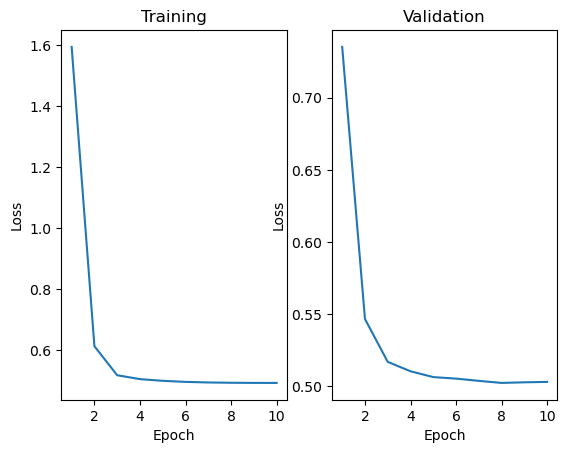

In [16]:

#plot 1:
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training')

#plot 2:
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation')

plt.show()
# plt.savefig('image.png')

In [15]:
torch.save(model.state_dict(), './model/model_v1.pth')